### Transform Learning 
Reference:  
https://blog.csdn.net/dahuayaoer/article/details/105200691

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [3]:
def get_dataset(data_dir):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'eval': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        
        'test': transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    data_dir = data_dir
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x]) for x in ['train', 'eval', 'test']}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                                shuffle=True, num_workers=4) for x in ['train', 'eval', 'test']}
    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'eval', 'test']}
    class_names = image_datasets['train'].classes

    device = device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return dataloaders, dataset_sizes, class_names, device


In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) 


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



Epoch 0/29
----------
train Loss: 2.4977 Acc: 0.4451
eval Loss: 1.0193 Acc: 0.7341

Epoch 1/29
----------
train Loss: 1.4997 Acc: 0.6191
eval Loss: 0.6566 Acc: 0.8110

Epoch 2/29
----------
train Loss: 1.2228 Acc: 0.6873
eval Loss: 0.7606 Acc: 0.8171

Epoch 3/29
----------
train Loss: 1.1176 Acc: 0.7171
eval Loss: 0.5044 Acc: 0.8573

Epoch 4/29
----------
train Loss: 1.0165 Acc: 0.7384
eval Loss: 0.4438 Acc: 0.8707

Epoch 5/29
----------
train Loss: 0.9876 Acc: 0.7425
eval Loss: 0.4592 Acc: 0.8841

Epoch 6/29
----------
train Loss: 0.9279 Acc: 0.7627
eval Loss: 0.4781 Acc: 0.8744

Epoch 7/29
----------
train Loss: 0.7002 Acc: 0.8210
eval Loss: 0.3746 Acc: 0.8951

Epoch 8/29
----------
train Loss: 0.6006 Acc: 0.8431
eval Loss: 0.3402 Acc: 0.9049

Epoch 9/29
----------
train Loss: 0.5911 Acc: 0.8502
eval Loss: 0.3203 Acc: 0.8927

Epoch 10/29
----------
train Loss: 0.5622 Acc: 0.8593
eval Loss: 0.3092 Acc: 0.9061

Epoch 11/29
----------
train Loss: 0.5428 Acc: 0.8653
eval Loss: 0.3289 Ac

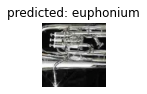

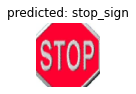

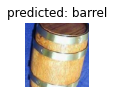

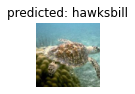

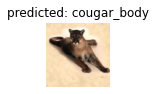

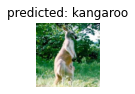

In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs,
                device, dataset_sizes, dataloaders):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'eval']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'eval' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best eval Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['eval']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)
    return 'train'


def get_full_transfer_model():
    model_ft = models.resnet18(pretrained=True)
    num_ftrs = model_ft.fc.in_features
 
    model_ft.fc = nn.Linear(num_ftrs, 101)

    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

    return model_ft, criterion, optimizer_ft, exp_lr_scheduler



def part_transfer():
    model_conv = torchvision.models.resnet18(pretrained=True)
    for param in model_conv.parameters():
        param.requires_grad = False

    # Parameters of newly constructed modules have requires_grad=True by default
    num_ftrs = model_conv.fc.in_features
    model_conv.fc = nn.Linear(num_ftrs, 2)

    model_conv = model_conv.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that only parameters of final layer are being optimized as
    # opposed to before.
    optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)
    return model_conv, criterion, optimizer_conv, exp_lr_scheduler




if __name__ == "__main__":
    plt.ion()   # interactive mode
    data_dir = '/kaggle/input/caltech101/Caltech101/'
    num_epochs = 30
    dataloaders, dataset_sizes, class_names, device = get_dataset(data_dir)


    model, criterion, optimizer, scheduler = get_full_transfer_model()
    model_ft = train_model(model, criterion, optimizer, scheduler, num_epochs,
                           device, dataset_sizes, dataloaders)

    mode = visualize_model(model_ft)


    
    plt.ioff()
    plt.show()


In [6]:
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  